# IN PIPELINE NOTEBOOK: CLEAN DATA

# 2: Inspecting + EDA of Clean Data

In [12]:
import os
import pandas as pd

In [13]:
# Read in clean data

clean_data_path = "../data/clean"

# Store df's in a dictionary
clean_dfs = {}
clean_dfs['holidays_events'] = pd.read_parquet(os.path.join(clean_data_path, "holidays_events.parquet"))
clean_dfs['oil'] = pd.read_parquet(os.path.join(clean_data_path, "oil.parquet"))
clean_dfs['stores'] = pd.read_parquet(os.path.join(clean_data_path, "stores.parquet"))
clean_dfs['main'] = pd.read_parquet(os.path.join(clean_data_path, "main.parquet"))

In [14]:
# Check out high-level info of our df's (same function as before)
def inspect_df(df_name, df):
    print(f" * {df_name}.dtypes: \n{df.dtypes}")
    print(f" * {df_name}.isnull().sum(): \n{df.isnull().sum()}")
    print(f" * {df_name}.shape: {df.shape}")
    print(f" * {df_name}.nunique() : \n{df.nunique()}")

for i, df_name in enumerate(clean_dfs):
    print(f"\n#### {i+1}/{len(clean_dfs)}: {df_name} ####")
    df = clean_dfs[df_name]
    inspect_df(df_name, df)


#### 1/4: holidays_events ####
 * holidays_events.dtypes: 
date                                                               datetime64[ns]
combo_('Local', 'Ambato', 'Holiday')                                        int64
combo_('Local', 'Guaranda', 'Holiday')                                      int64
combo_('Local', 'Ibarra', 'Holiday')                                        int64
combo_('Local', 'Latacunga', 'Holiday')                                     int64
combo_('Local', 'Loja', 'Holiday')                                          int64
combo_('Local', 'Quevedo', 'Holiday')                                       int64
combo_('Local', 'Quito', 'Additional')                                      int64
combo_('Local', 'Quito', 'Holiday')                                         int64
combo_('Local', 'Riobamba', 'Holiday')                                      int64
combo_('Local', 'Salinas', 'Holiday')                                       int64
combo_('National', 'Ecuador', 'Additio

## Visualize features

In [15]:
main_features_to_plot = ['id', 'date', 'store_nbr', 'family', 'onpromotion', 'sales', 'log_sales']
main_features_to_plot += [col for col in list(clean_dfs['main'].columns) if "lag16_window365" in col]


#### 1/4: holidays_events ####
Histograms of numerical data: 


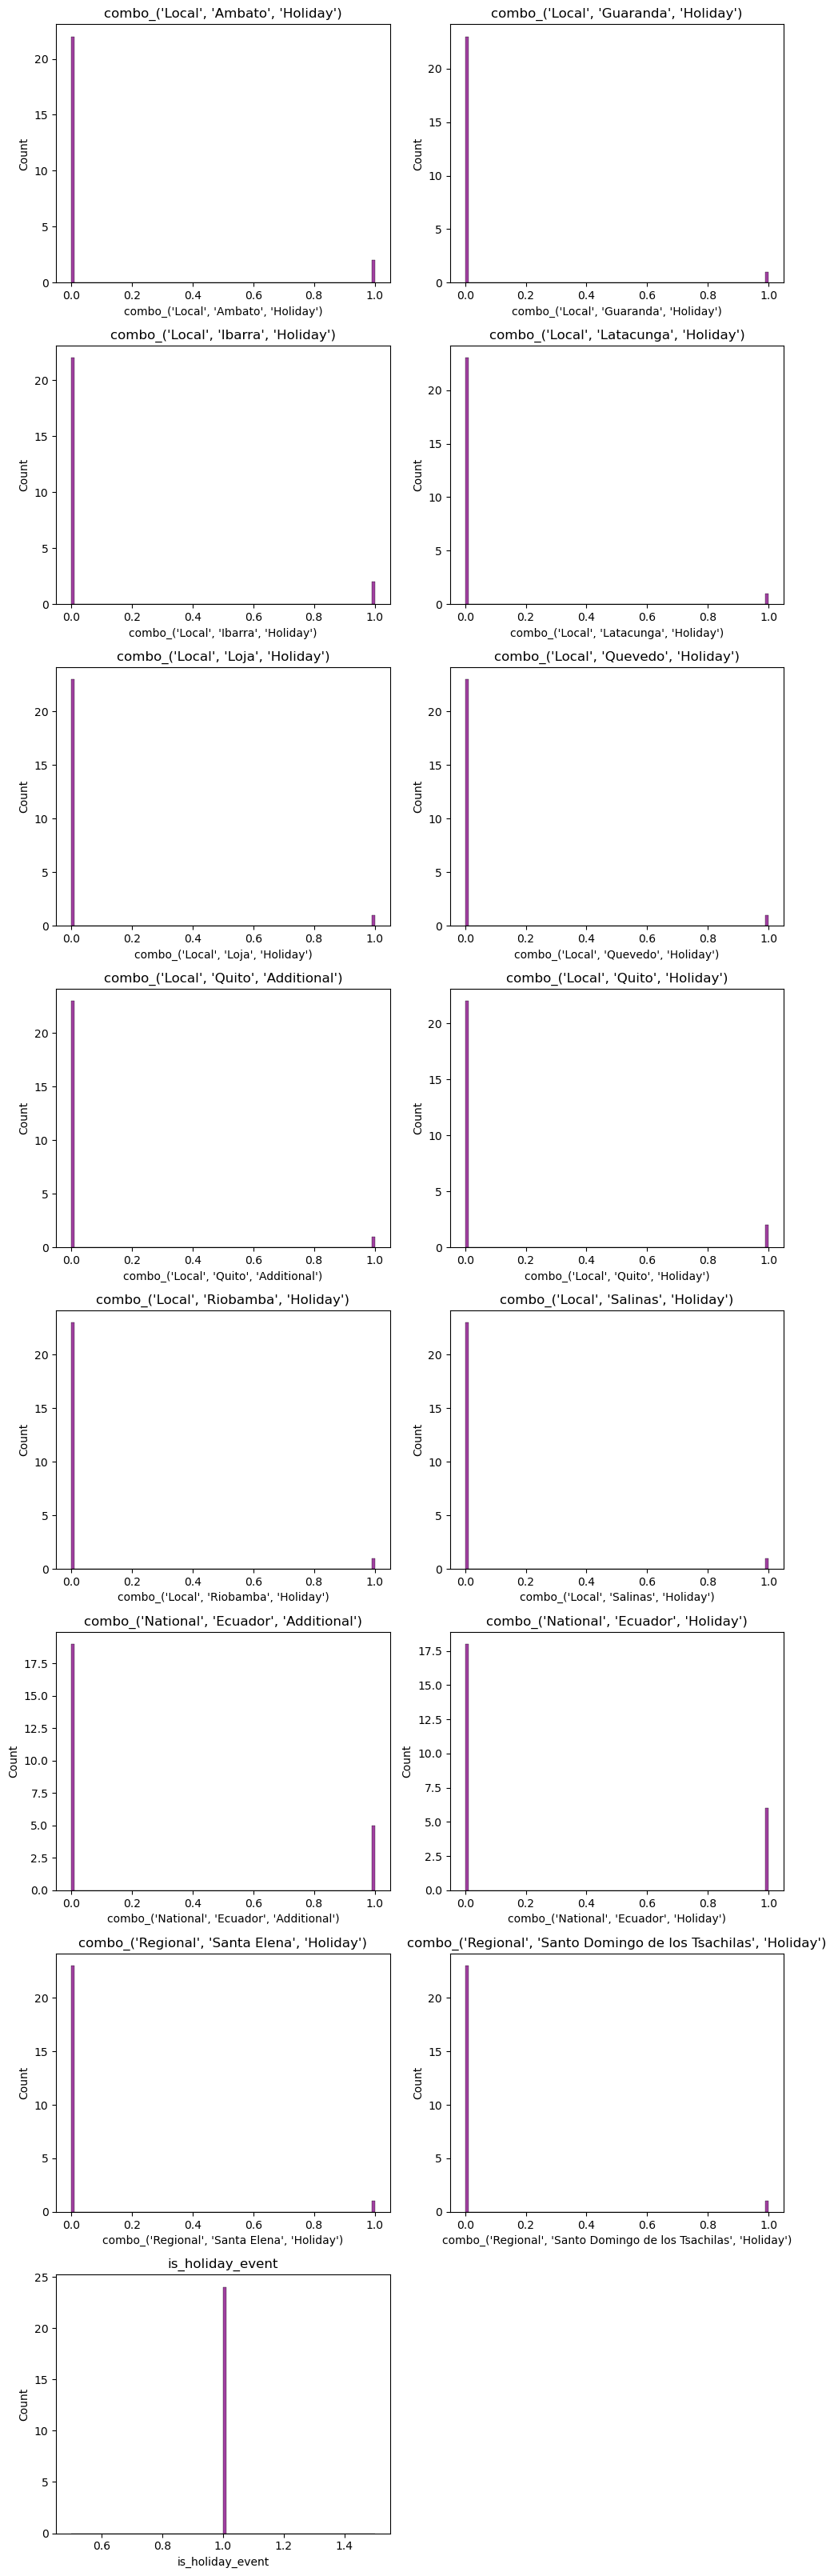

Barplots of categorical data: 


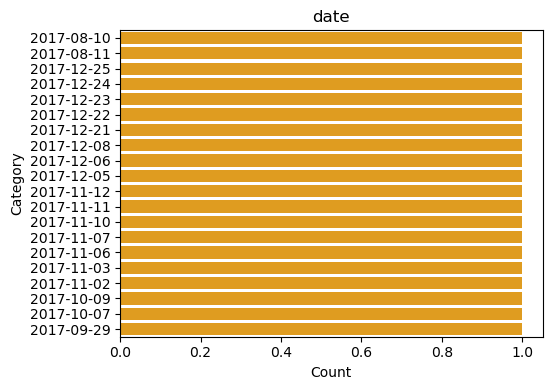


#### 2/4: oil ####
Histograms of numerical data: 


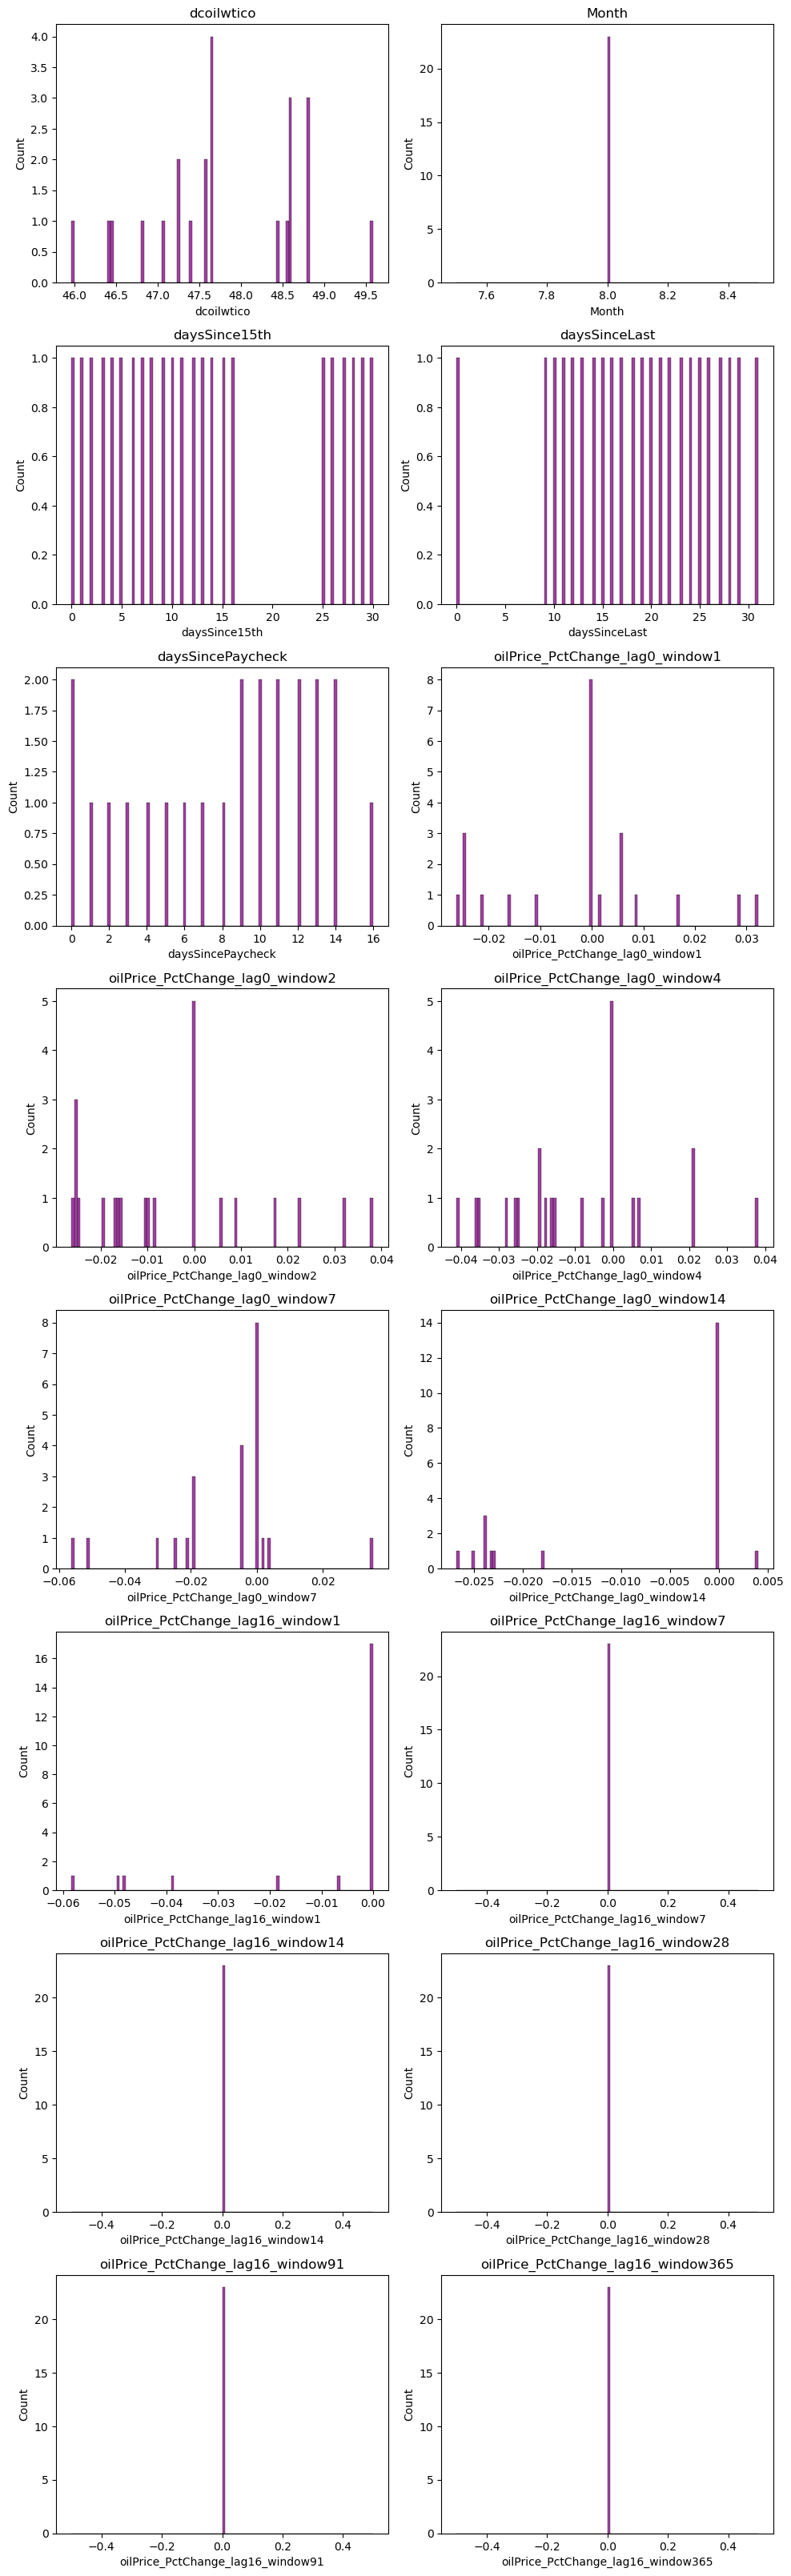

Barplots of categorical data: 


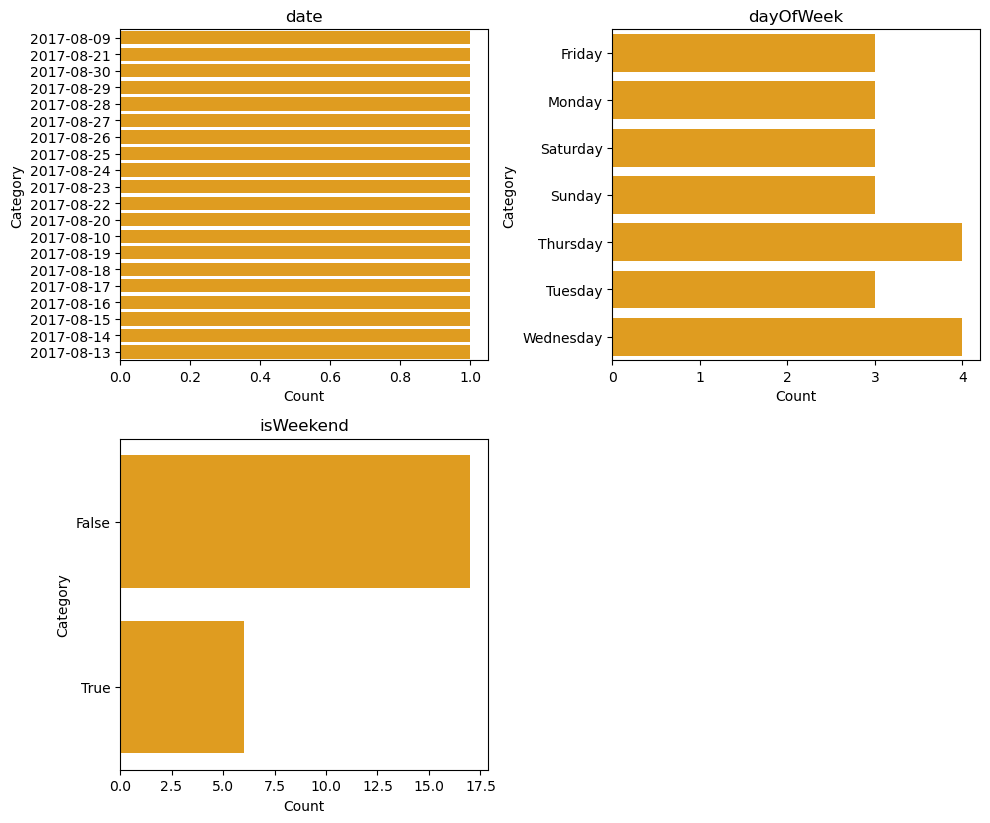


#### 3/4: stores ####
Histograms of numerical data: 


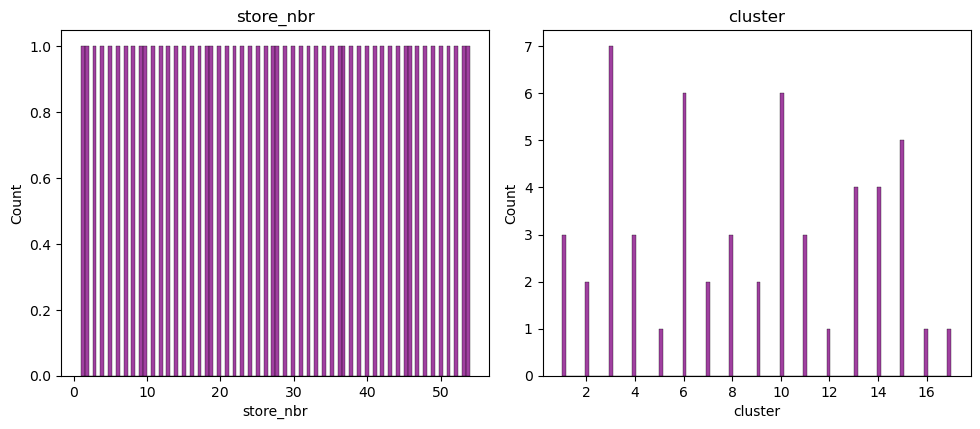

Barplots of categorical data: 


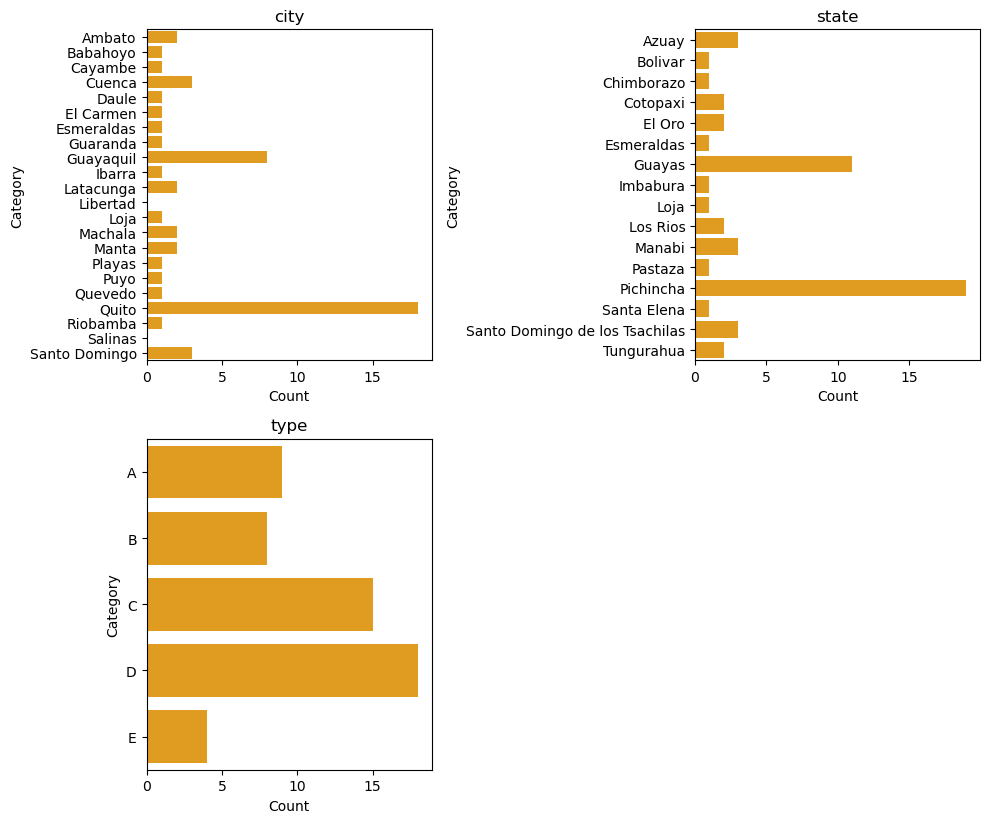


#### 4/4: main ####
Histograms of numerical data: 


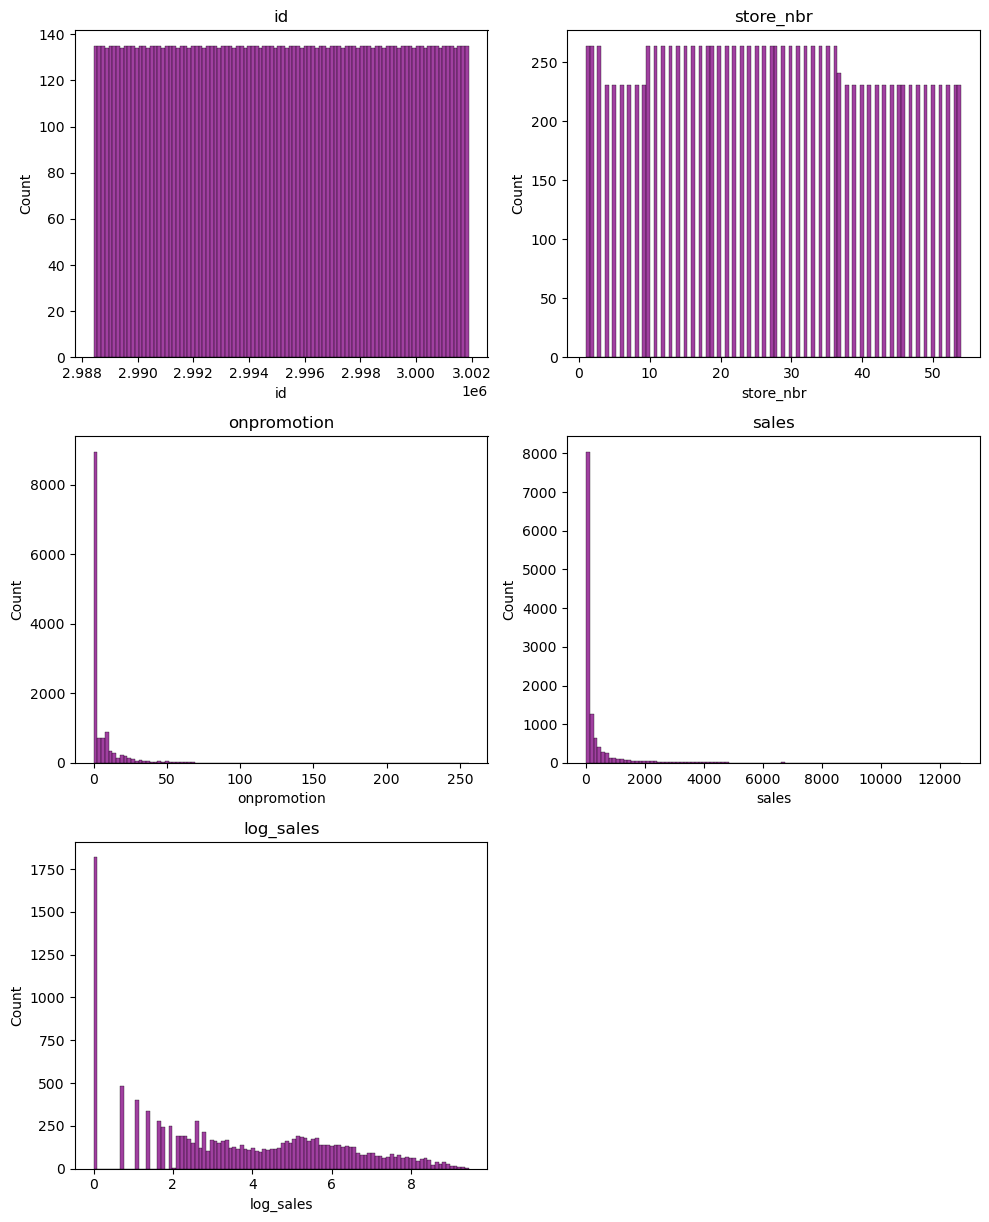

Barplots of categorical data: 


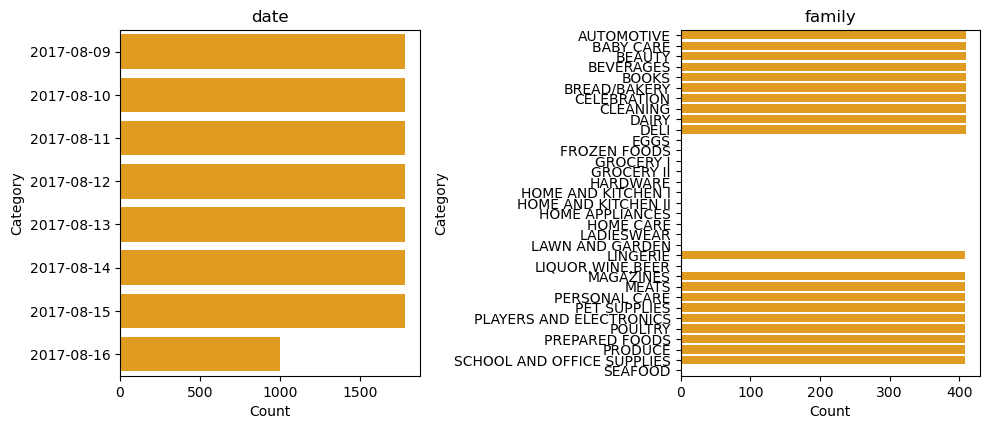

In [16]:
# Univariate visualizations

# Make histogram of each numerical column
# Make bar plot of each categorical column
import seaborn as sns
import matplotlib.pyplot as plt


def make_histograms(df_name, df):
    numeric_cols = df.select_dtypes(include='number').columns

    # Set up the layout
    n_rows = len(numeric_cols)
    plt.figure(figsize=(10, 4 * n_rows))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, 2, i)
        sns.histplot(df[col].dropna(), bins=100, color='purple')
        plt.title(col)

    plt.tight_layout()
    plt.show()


def make_barplots(df_name, df):
    object_cols = df.select_dtypes(exclude='number').columns
    n_rows = len(object_cols)
    plt.figure(figsize=(10, 4 * n_rows))

    for i, col in enumerate(object_cols, 1):
        plt.subplot(n_rows, 2, i)
        counts = df[col].value_counts().head(20)  # top 20 categories
        sns.barplot(x=counts.values, y=counts.index, orient='h', color='orange')
        plt.title(col)
        plt.xlabel("Count")
        plt.ylabel("Category")

    plt.tight_layout()
    plt.show()


for i, df_name in enumerate(clean_dfs):
    print(f"\n#### {i+1}/{len(clean_dfs)}: {df_name} ####")
    df = clean_dfs[df_name]
    if df_name == "main":
        df = df[main_features_to_plot]

    print(f"Histograms of numerical data: ")
    make_histograms(df_name, df)
    print(f"Barplots of categorical data: ")
    make_barplots(df_name, df)

In [17]:
# For merging with main
def merge_with_main(main, other_df, to_merge_on='date', fill_num_nas=None):
    num_cols = other_df.select_dtypes(include='number').columns

    merged = pd.merge(
        main,
        other_df,
        on=to_merge_on,
        how='left'
    )

    if fill_num_nas != None:
        assert type(fill_num_nas) == int, f"Please make 'fill_num_nas' an int"
        merged[num_cols] = merged[num_cols].fillna(fill_num_nas)
    return merged


#### Correlations of numerical features in 'main' with 'sales' ####


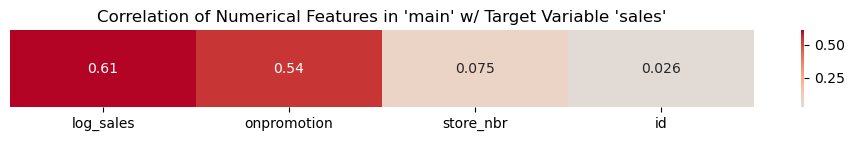

#### Correlations of numerical features in 'oil' with 'sales' ####


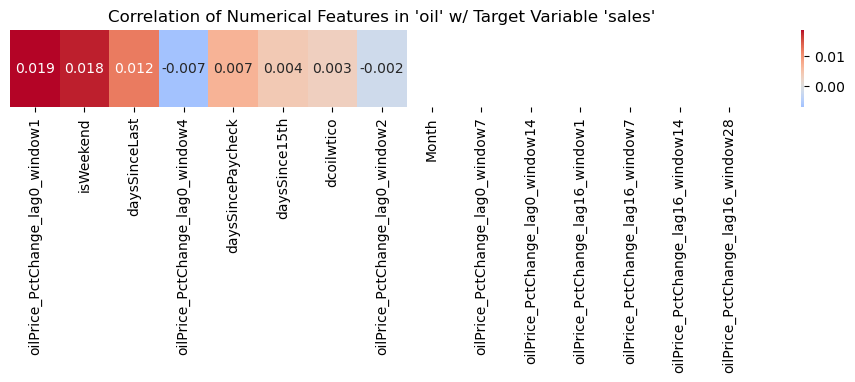

#### Correlations of numerical features in 'holidays_events' with 'sales' ####


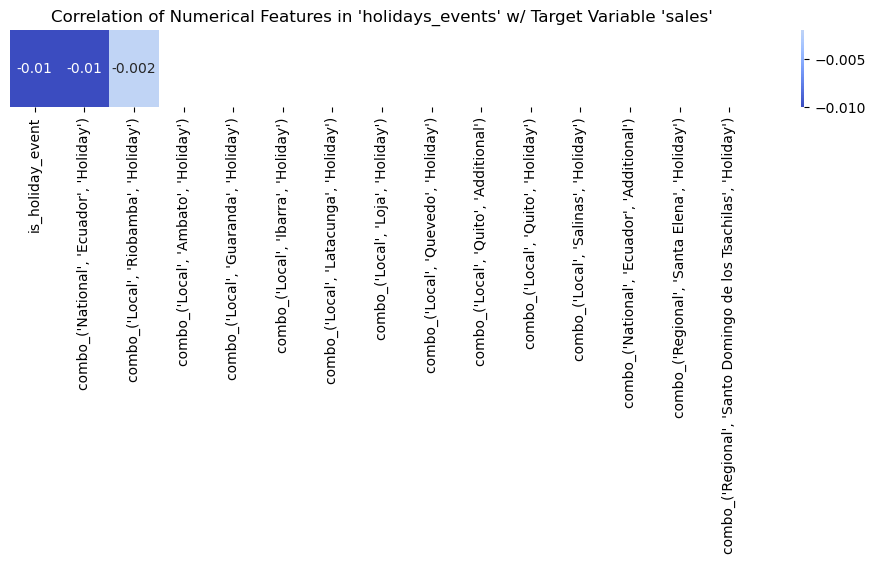

#### Correlations of numerical features in 'stores' with 'sales' ####


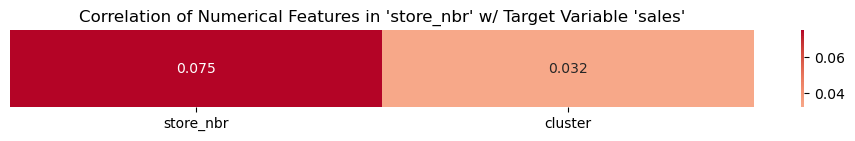

In [18]:
def calc_corrs(df, df_name="main", target_col='sales'):
    """
    Gives dataframe where each row is a correlation to target, sorted highest abs to lowest abs
    """
    correlation = df.corr(numeric_only=True)[target_col].drop(target_col)
    correlation = correlation.reindex(correlation.abs().sort_values(ascending=False).index)

    # Convert to DataFrame
    return correlation.to_frame()


# Heat map against the target variable
def corr_heatmap_against_target(df, df_name='main', target_col='sales', max=15, precision=3):
    # Compute correlations with the target variable
    correlation_df = calc_corrs(
        df,
        df_name,
        target_col
    ).iloc[:max].round(precision).T  # make it a row to heatmap it horizontally

    # Plot the heatmap
    plt.figure(figsize=(12, 1))  # Adjust height to make it thin
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
    plt.title(f"Correlation of Numerical Features in '{df_name}' w/ Target Variable '{target_col}'")
    plt.yticks([])  # optional: hides the y-axis (since it's just one row)
    plt.show()


# Check correlations within 'main'
print(f"#### Correlations of numerical features in 'main' with 'sales' ####")
corr_heatmap_against_target(
    clean_dfs['main'][main_features_to_plot]
)

# Check correlations with 'oil'
print(f"#### Correlations of numerical features in 'oil' with 'sales' ####")
corr_heatmap_against_target(
    merge_with_main(clean_dfs['main'][['date', 'sales']], clean_dfs['oil'], fill_num_nas=0),
    df_name='oil'
)

# Check correlations with 'holidays_events'
print(f"#### Correlations of numerical features in 'holidays_events' with 'sales' ####")
corr_heatmap_against_target(
    merge_with_main(clean_dfs['main'][['date', 'sales']], clean_dfs['holidays_events'], fill_num_nas=0),
    df_name='holidays_events'
)

# Check correlations with 'stores'
print(f"#### Correlations of numerical features in 'stores' with 'sales' ####")
corr_heatmap_against_target(
    merge_with_main(clean_dfs['main'][['store_nbr', 'sales']], clean_dfs['stores'], to_merge_on='store_nbr'),
    df_name='store_nbr'
)

#### Scatterplots of numerical features in 'main' with 'sales' ####


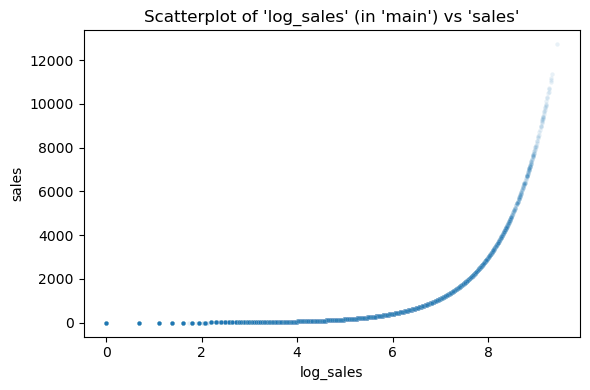

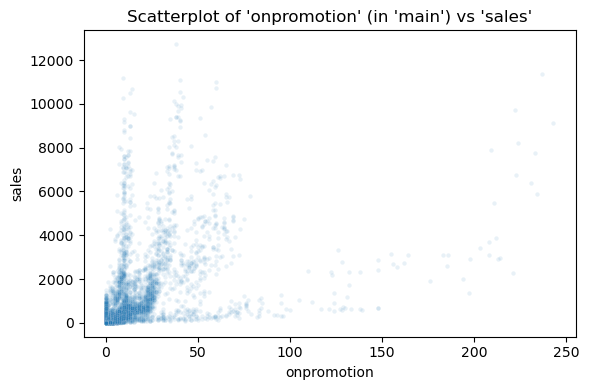

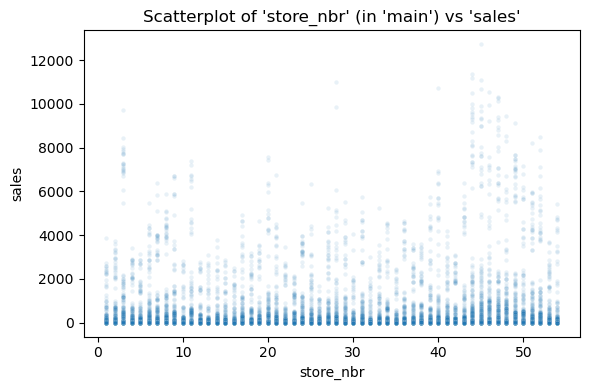

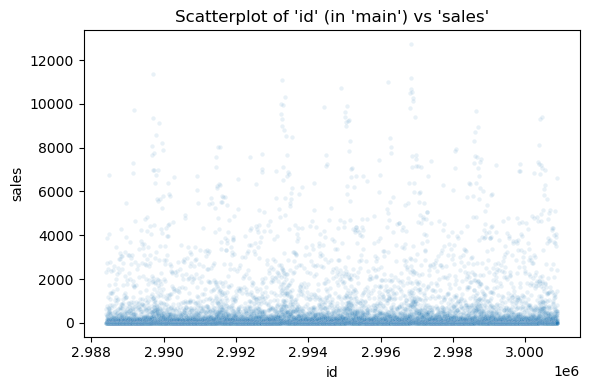

#### Scatterplots of numerical features in 'oil' with 'sales' ####


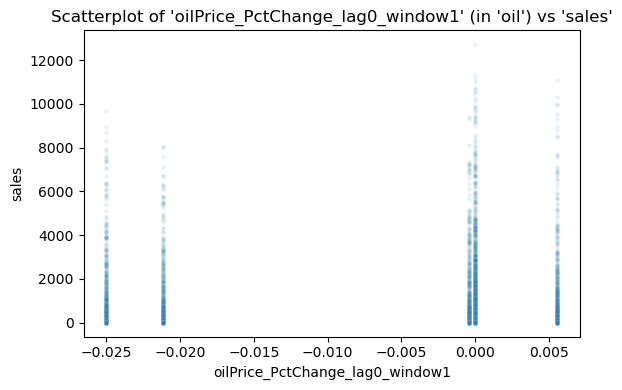

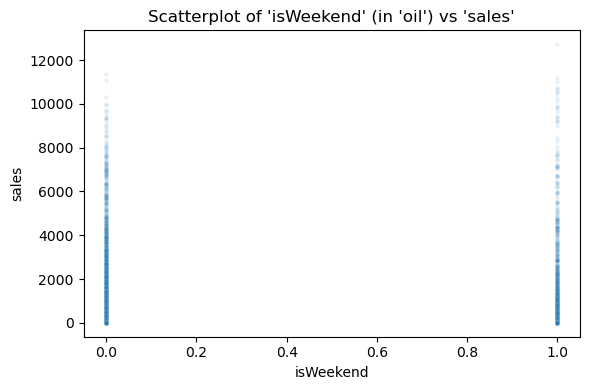

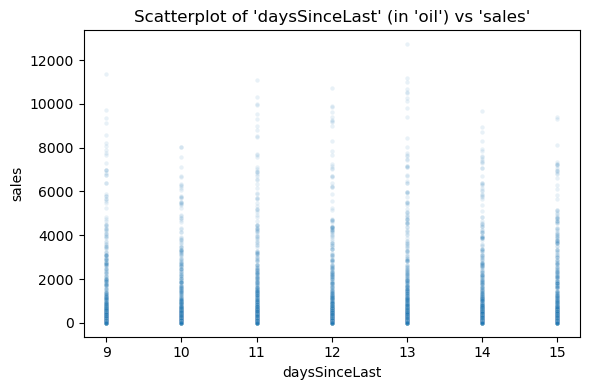

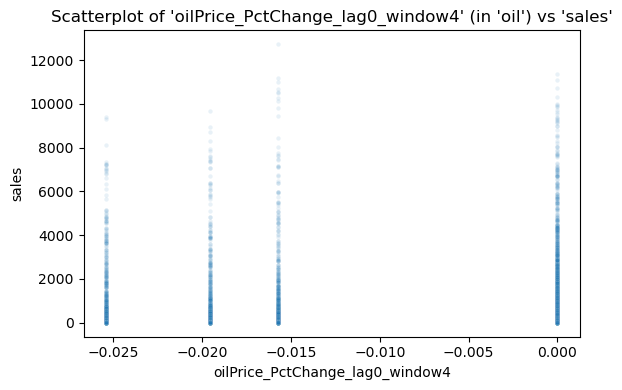

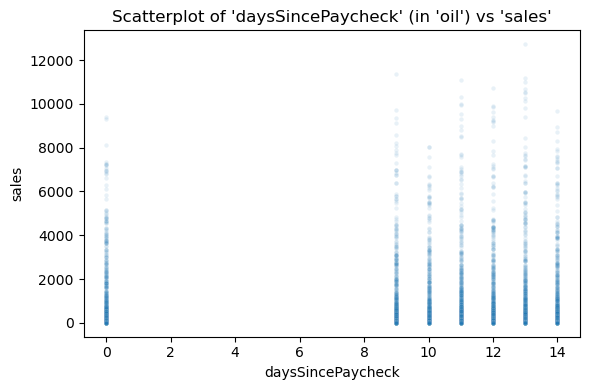

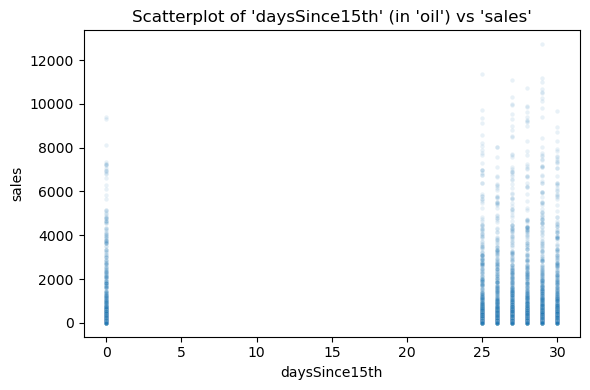

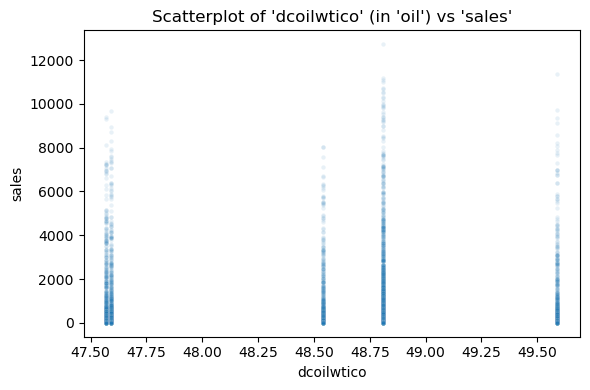

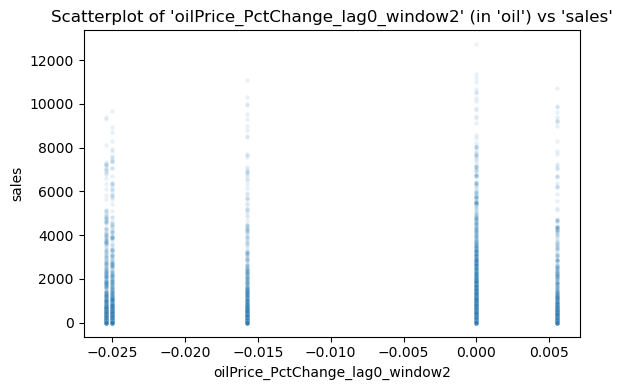

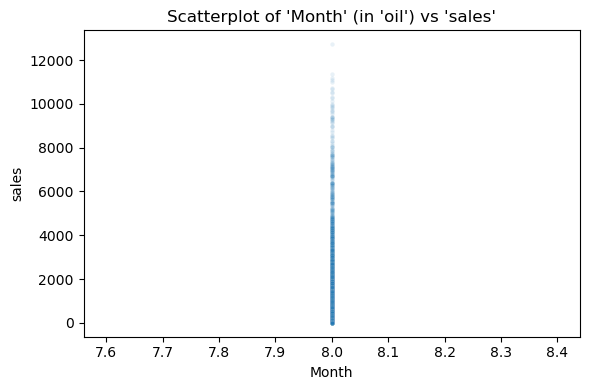

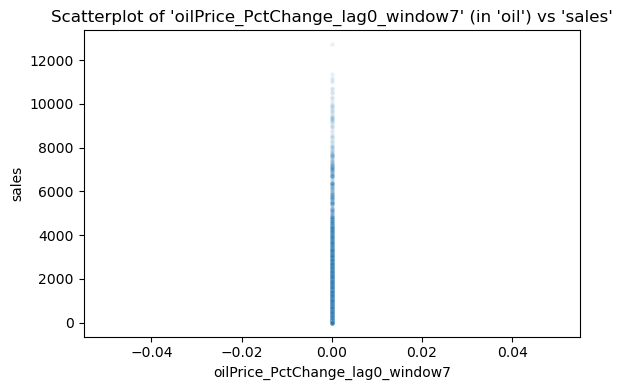

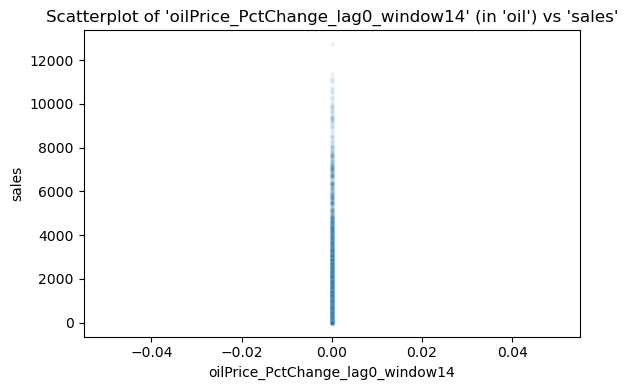

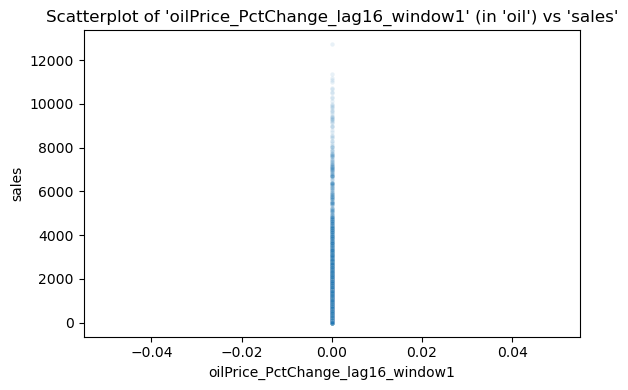

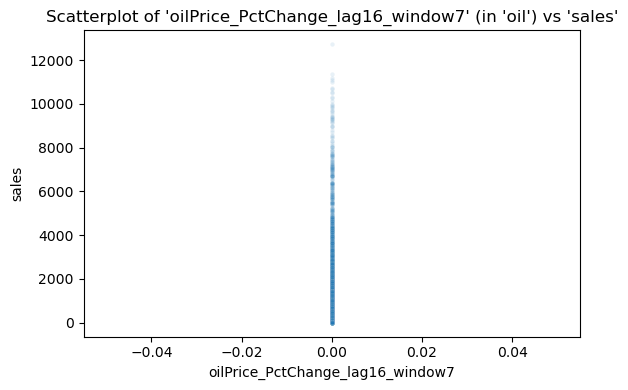

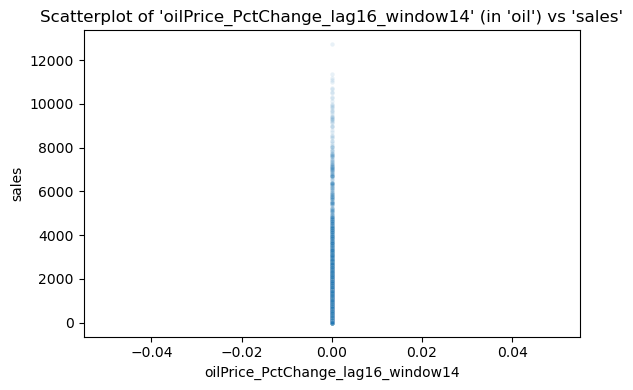

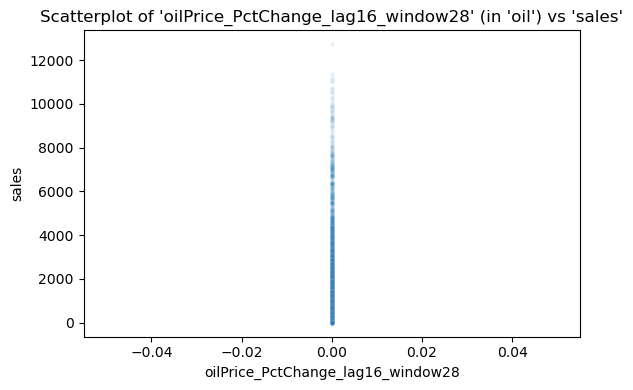

#### Scatterplots of numerical features in 'holidays_events' with 'sales' ####


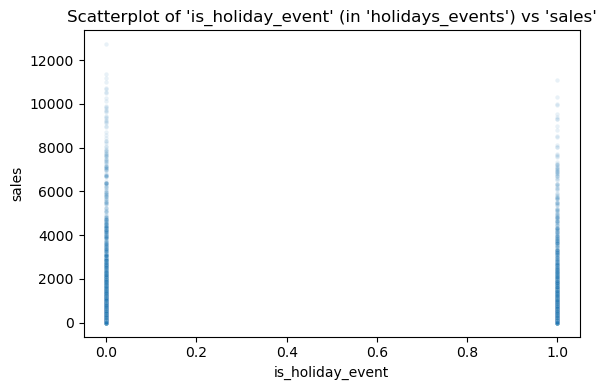

#### Scatterplots of numerical features in 'stores' with 'sales' ####


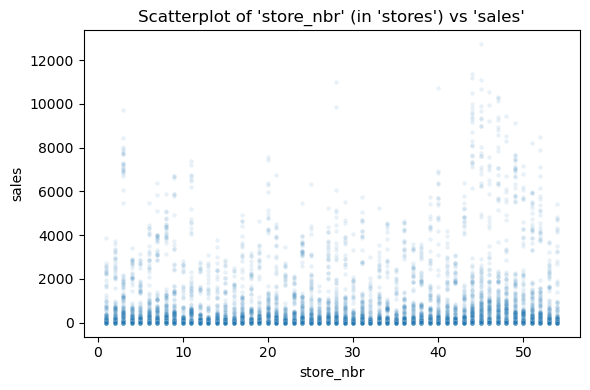

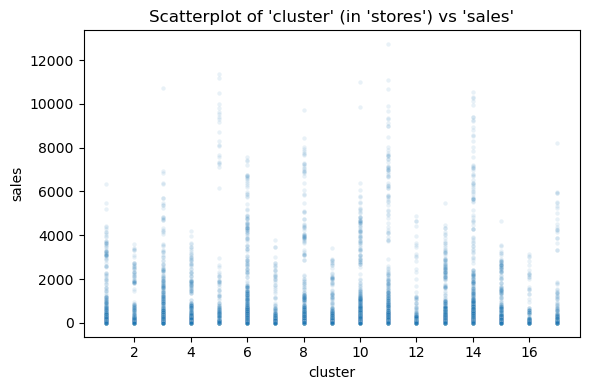

In [19]:
# Scatter plots of numerical features against target variable
def scatter_plot_against_target(df, df_name='main', target_col='sales', max=15):
    correlation_df = calc_corrs(
        df,
        df_name,
        target_col
    ).iloc[:max].T

    # Loop through each numerical feature
    for col in correlation_df.select_dtypes(include='number').columns:
        if col == target_col:
            continue  # skip the target itself

        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df, x=col, y=target_col, alpha=0.1, s=10)
        plt.title(f"Scatterplot of '{col}' (in '{df_name}') vs '{target_col}'")
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.tight_layout()
        plt.show()

# Check scatterplots within 'main'
print(f"#### Scatterplots of numerical features in 'main' with 'sales' ####")
scatter_plot_against_target(
    clean_dfs['main'][main_features_to_plot]
)

# Check scatterplots with 'oil'
print(f"#### Scatterplots of numerical features in 'oil' with 'sales' ####")
scatter_plot_against_target(
    merge_with_main(clean_dfs['main'][['date', 'sales']], clean_dfs['oil'], fill_num_nas=0),
    df_name='oil'
)

# Check scatterplots with 'holidays_events'
print(f"#### Scatterplots of numerical features in 'holidays_events' with 'sales' ####")
scatter_plot_against_target(
    merge_with_main(
        clean_dfs['main'][['date', 'sales']],
        clean_dfs['holidays_events'][['date', 'is_holiday_event']],
        fill_num_nas=0
    ),
    df_name='holidays_events'
)

# Check scatterplots with 'stores'
print(f"#### Scatterplots of numerical features in 'stores' with 'sales' ####")
scatter_plot_against_target(
    merge_with_main(clean_dfs['main'][['store_nbr', 'sales']], clean_dfs['stores'], to_merge_on='store_nbr'),
    df_name='stores'
)


* Ensure no duplicate rows

* Missing data/Imputation Strategy:
    * sns.heatmap(df.isnull())
    * Figure out whether to drop or impute

#### Violin Plots of categorical features in 'main' with 'sales' ####


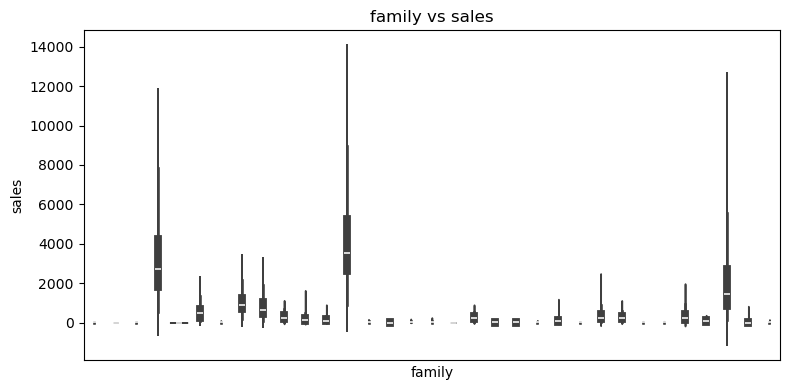

#### Violin Plots of categorical features in 'oil' with 'sales' ####


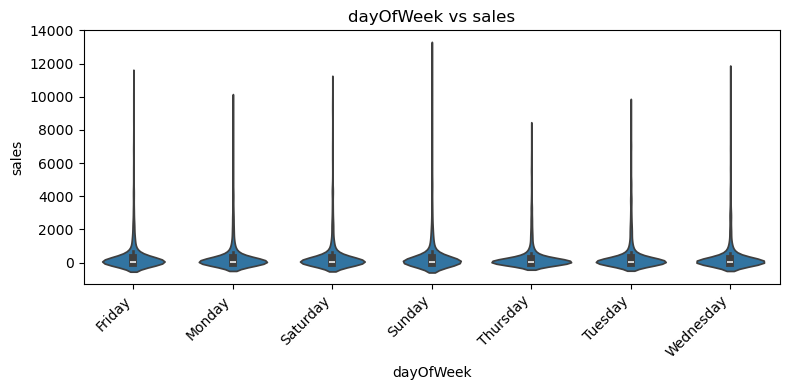

#### Violin Plots of categorical features in 'holidays_events' with 'sales' ####
#### Violin Plots of categorical features in 'stores' with 'sales' ####


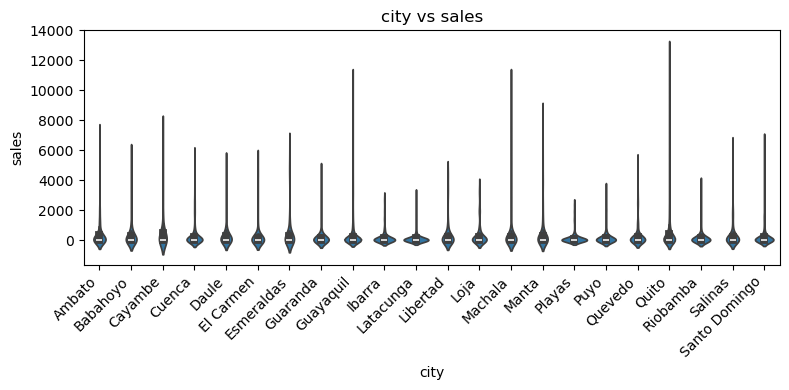

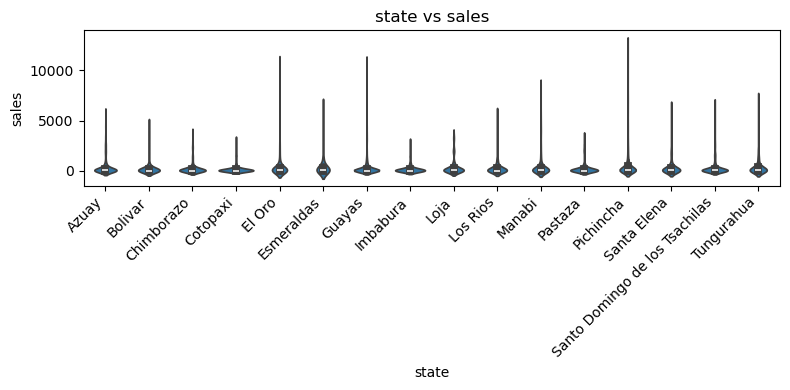

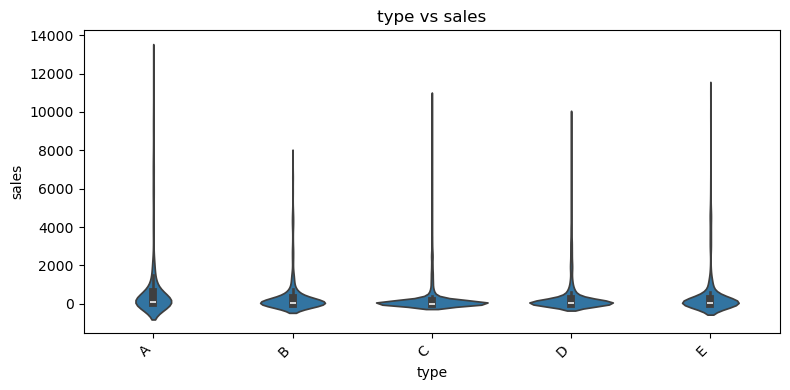

In [20]:
def violin_plot_against_target(df, df_name='main', target_col='sales', max_labels=25):
    # Loop through categorical columns
    for col in df.select_dtypes(include='category').columns:
        num_categories = df[col].nunique()
        plt.figure(figsize=(8, 4))
        sns.violinplot(data=df, x=col, y=target_col)
        plt.title(f'{col} vs {target_col}')
        if num_categories > max_labels:
            plt.xticks([], [])  # completely remove x-axis labels and ticks
        else:
            plt.xticks(rotation=45, ha='right')  # otherwise rotate labels
        plt.tight_layout()
        plt.show()

# Check violinplots within 'main'
print(f"#### Violin Plots of categorical features in 'main' with 'sales' ####")
violin_plot_against_target(
    clean_dfs['main'][main_features_to_plot]
)

# Check violinplots with 'oil'
print(f"#### Violin Plots of categorical features in 'oil' with 'sales' ####")
violin_plot_against_target(
    merge_with_main(clean_dfs['main'][['date', 'sales']], clean_dfs['oil'], fill_num_nas=0),
    df_name='oil'
)

# Check violinplots with 'holidays_events'
print(f"#### Violin Plots of categorical features in 'holidays_events' with 'sales' ####")
violin_plot_against_target(
    merge_with_main(
        clean_dfs['main'][['date', 'sales']],
        clean_dfs['holidays_events'].drop(columns=[col for col in clean_dfs['holidays_events'].columns if col.startswith('combo_')]),
        fill_num_nas=0
    ),
    df_name='holidays_events'
)

# Check violinplots with 'stores'
print(f"#### Violin Plots of categorical features in 'stores' with 'sales' ####")
violin_plot_against_target(
    merge_with_main(clean_dfs['main'][['store_nbr', 'sales']], clean_dfs['stores'], to_merge_on='store_nbr'),
    df_name='stores'
)


# 3: ML Time!

In [21]:
main_df = clean_dfs['main']
print(main_df.date.min())
print(main_df.date.max())
print()

print(main_df[main_df['is_train'] == 1].date.min())
print(main_df[main_df['is_train'] == 1].date.max())
print()

print(main_df[main_df['is_test'] == 1].date.min())
print(main_df[main_df['is_test'] == 1].date.max())
print()

2017-08-09 00:00:00
2017-08-16 00:00:00

2017-08-09 00:00:00
2017-08-15 00:00:00

2017-08-16 00:00:00
2017-08-16 00:00:00

